In [1]:
import os
import sys
import numpy as np
import math
from scipy.sparse.csgraph import laplacian
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats


cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

from matrix_operation import mat_opr
from nmf_clustering import nmf_cluster

## Prepare the Laplacian

In [2]:
state_dset = pd.read_csv(os.path.join(par,'collected_data/state_dataset.csv'), index_col = 0)
state_dset = mat_opr(state_dset)
s_adj = pd.read_csv(os.path.join(par, "collected_data/state_adjacency.csv"), index_col = 0)
state_adj = pd.DataFrame(columns = state_dset.dataframe.columns, index = state_dset.dataframe.columns)

In [3]:
state_map = gp.read_file('US_States_geojson.json')
state_caps = pd.read_csv(os.path.join(par, "collected_data/us_state_capitals.csv"))

In [4]:
for ind in s_adj.index:
    st = s_adj.loc[ind,'state']
    ad = s_adj.loc[ind, 'adj']
    dist = s_adj.loc[ind, 'distance']
    state_adj.loc[st,ad] = 1
state_adj = state_adj.replace(np.nan, 0)

In [5]:
L = np.array(laplacian(state_adj))
I = np.identity(len(L))

In [11]:
Lsave = pd.DataFrame(L, columns = state_dset.dataframe.columns, index = state_dset.dataframe.columns)

In [13]:
Lsave.to_csv(os.path.join(par, "state_laplacian.csv"))

## NMF for comparison

In [14]:
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')

In [15]:
# ia0 and normalize:
state_iso = state_dset.known_iso()
#normy = state_iso.normalizer()

In [16]:
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [17]:
nmfed = nmf_cluster(state_norm.dataframe, 4, clusters=None, cluster_method='kmeans', num_outliers=None)

C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\geopandas\plotting.py:824: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.draw()
C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\geopandas\plotting.py:824: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.draw()
C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\geopandas\plotting.py:824: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.draw()
C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\geopandas\plotting.py:824: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.draw()
C:\Users\kq146\anaconda3\envs\covid_env\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figu

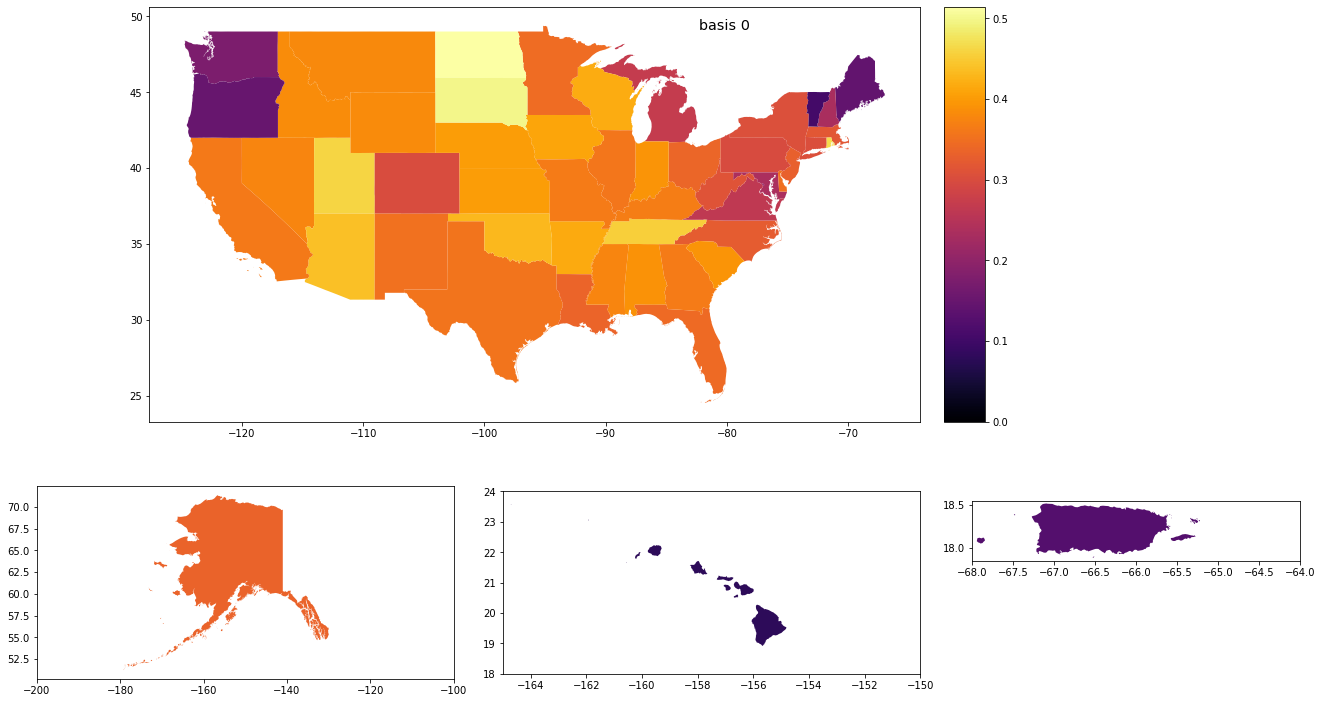

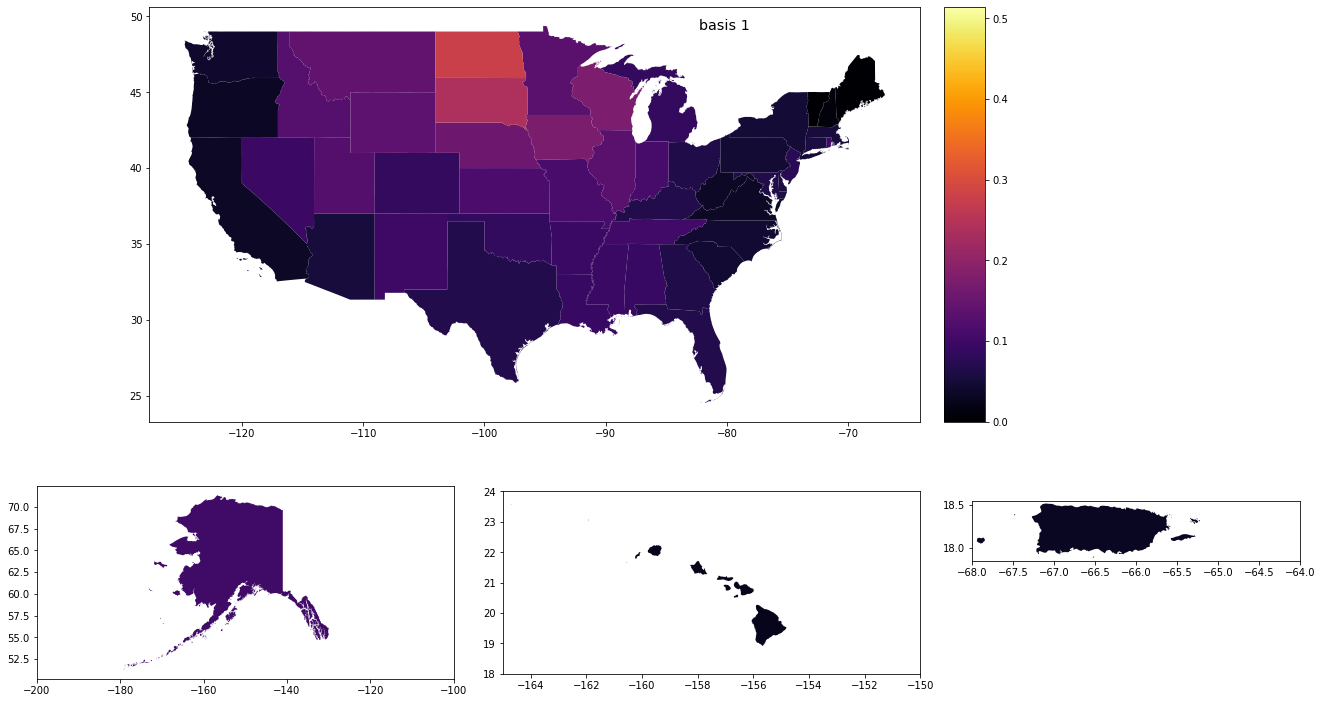

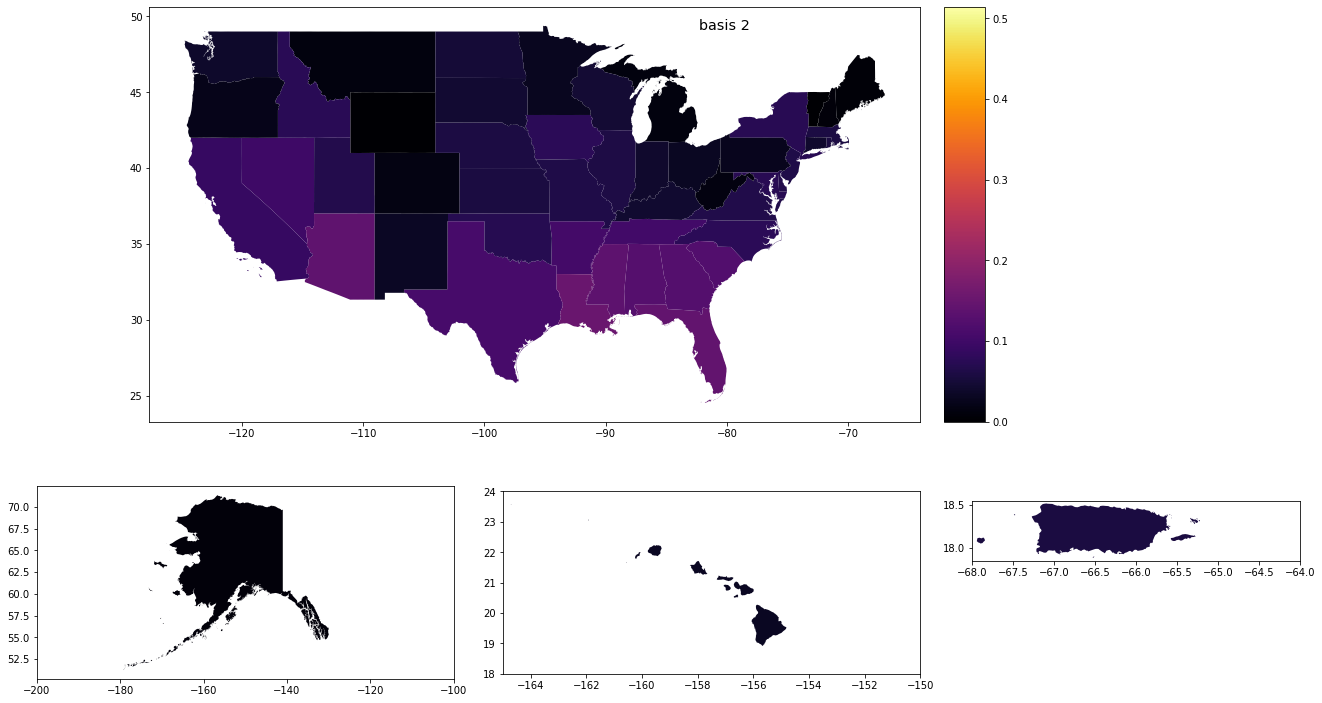

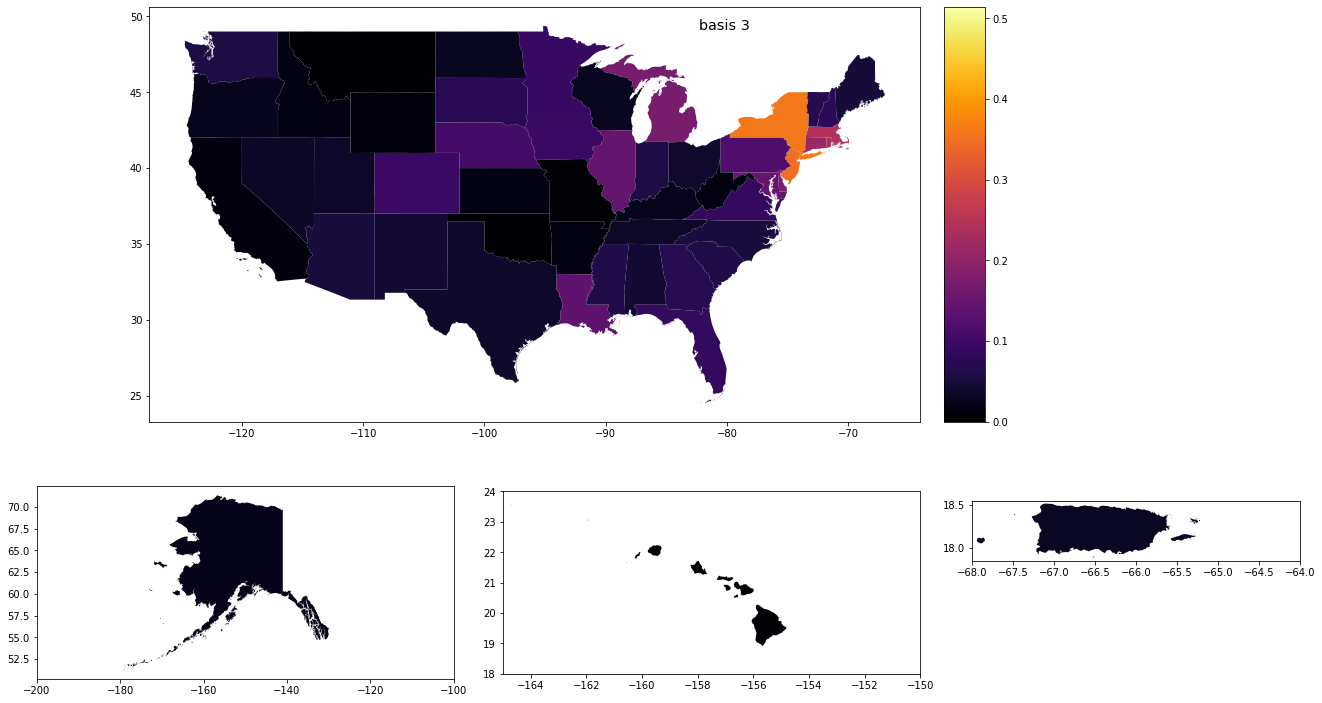

In [18]:
nmfed.state_map_basis()

In [19]:
nmfed.y_table.columns = state_norm.dataframe.columns

## Tune for Lambda

In [20]:
lambd = 1
Kinv = I + lambd * L
K = np.linalg.inv(Kinv)

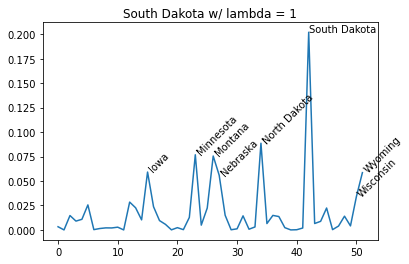

In [22]:
diff = pd.DataFrame(K, columns = state_adj.columns, index = state_adj.index)

state = 'South Dakota'
quant = diff.loc[:,state].quantile(0.85)
gep = diff.loc[:,state]
gep.index = range(len(gep.index))
cords = gep.loc[gep >= quant]

diff.loc[:,state].plot()
for point in cords.index:
    if diff.index[point] != state:
        plt.annotate(diff.index[point], (point, cords.loc[point]), rotation=45)
    else:
        plt.annotate(diff.index[point], (point, cords.loc[point]))
plt.title(state + ' w/ lambda = ' + str(lambd))
plt.show()

<ipython-input-23-229b0dba0d4c>:7: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%")


(-200.0, -25.0)

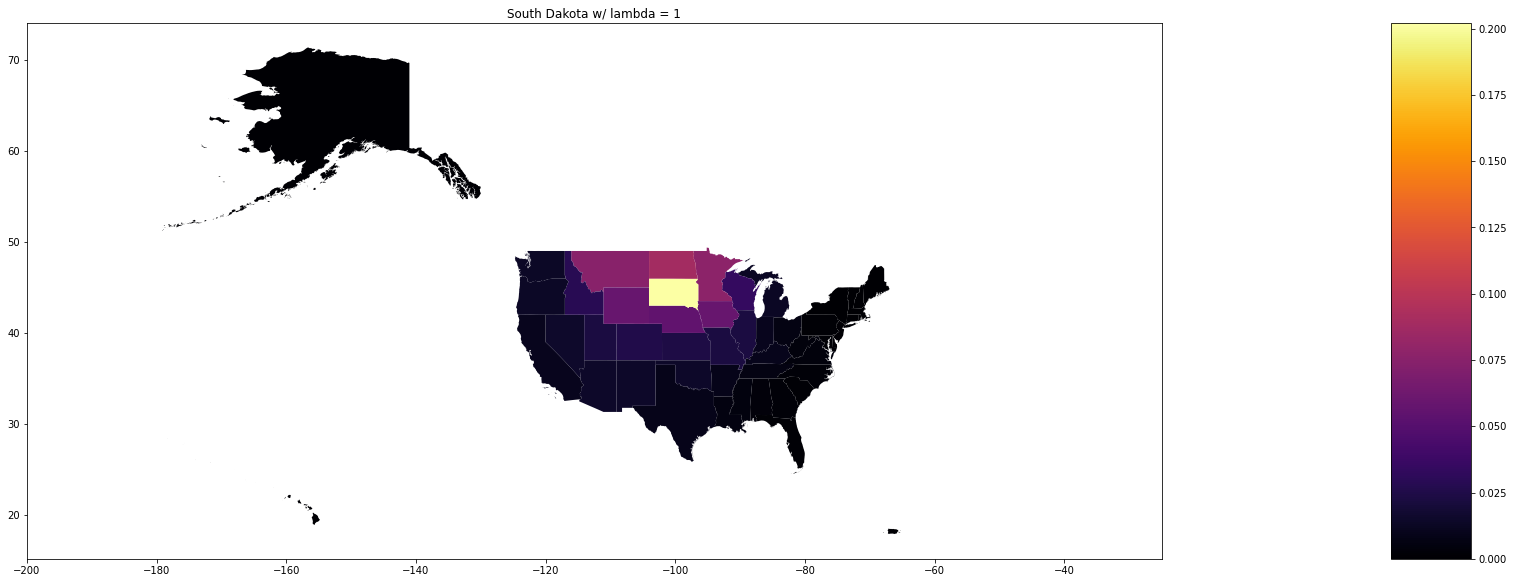

In [23]:
color_col = []
for state2 in state_map.NAME:
    color_col.append(diff.loc[state2,state])
state_map['cluster'] = color_col
fig,ax = plt.subplots(1,1,figsize = (30,30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%") 
state_map.plot(column = "cluster", ax = ax,cax=cax, cmap = 'inferno', legend = True)
ax.set_title(state + ' w/ lambda = ' + str(lambd))
ax.set_xlim(-200,-25)

In [24]:
x = range(1,100)
y = []
for beta in range(1,100):
    Kinv_i = I + beta * L
    K_i = np.linalg.inv(Kinv_i)
    diffy = pd.DataFrame(K_i, columns = state_adj.columns, index = state_adj.index)
    y.append(diffy.std().mean())

Text(0.5, 1.0, 'Average standard deviation for lambda = x')

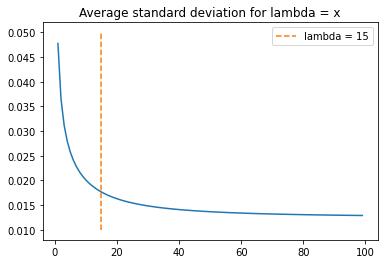

In [25]:
choice = 15
plt.plot(x,y)
plt.vlines(x=choice, ymin=0.01, ymax= 0.05, color="tab:orange", linestyle='dashed', label="lambda = " + str(choice))
plt.legend()
plt.title("Average standard deviation for lambda = x")

## Correlation between K and NMF

In [26]:
nmfed.y_table

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
basis 0,0.390952,0.333858,0.438719,0.417029,0.362228,0.301305,0.304096,0.350001,0.202072,0.344478,...,0.499470,0.454517,0.357412,0.460923,0.106427,0.262463,0.175897,0.312136,0.418367,0.382587
basis 1,0.091176,0.101424,0.053160,0.092845,0.035130,0.087487,0.056642,0.056517,0.059874,0.068177,...,0.237301,0.103088,0.067342,0.125238,0.000000,0.034454,0.041332,0.035525,0.175199,0.135888
basis 2,0.128161,0.009032,0.139553,0.105538,0.088714,0.016985,0.040311,0.066942,0.079530,0.143705,...,0.044300,0.103854,0.110342,0.067179,0.000000,0.065438,0.038560,0.015731,0.046976,0.000000
basis 3,0.046138,0.022577,0.053416,0.017407,0.013941,0.093996,0.214552,0.175019,0.211711,0.084661,...,0.074763,0.034481,0.039372,0.037553,0.068592,0.088356,0.060780,0.014996,0.028613,0.010696


In [27]:
x2 = range(1,50)
wave = 1
glob_max = -1
glob_y = []
glob_state = None
glob_lambd = 1


for geo_loc in nmfed.y_table.columns:
    y2 = []
    beta_best = 1
    corr_max = -1
    #geo_loc = 'Florida'
    
    for beta in x2:
        Kinv_i = I + beta * L
        K_i = np.linalg.inv(Kinv_i)
        diffy = pd.DataFrame(K_i, columns = state_adj.columns, index = state_adj.index)
        corr = stats.pearsonr(np.array(diffy.loc[:,geo_loc]), np.array(nmfed.y_table.iloc[wave,:]))

        if corr[0] > corr_max:
            beta_best = beta
            corr_max = corr[0]

        y2.append(corr[0])
        
    if max(y2) > glob_max:
        glob_max = max(y2)
        glob_y = y2
        glob_state = geo_loc
        glob_lambd = beta_best

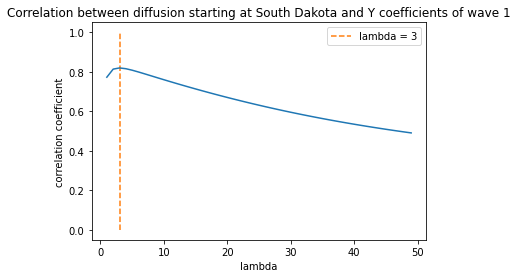

In [28]:
plt.plot(x2,glob_y)
plt.vlines(x=glob_lambd, ymin=0, ymax= 1, color="tab:orange", linestyle='dashed', label="lambda = " + str(glob_lambd))
plt.legend()
plt.title("Correlation between diffusion starting at " + str(glob_state) + " and Y coefficients of wave " + str(wave))
plt.xlabel('lambda')
plt.ylabel('correlation coefficient')
plt.show()

## K analysis

Text(0.5, 0, 'Beta value')

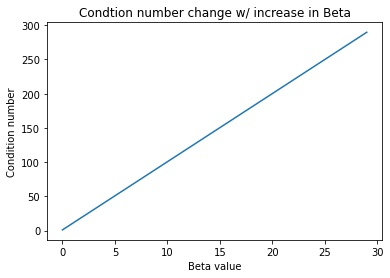

In [32]:
x = range(30)
y = []
for b in range(30):
    Ka = np.linalg.inv(I + b * L)
    y.append(np.linalg.cond(Ka))
    
plt.plot(x, y)
plt.title("Condtion number change w/ increase in Beta")
plt.ylabel("Condition number")
plt.xlabel("Beta value")

In [37]:
w,h = np.linalg.eig(K)

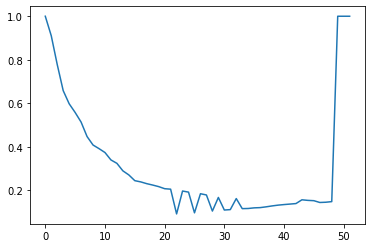

In [40]:
plt.plot(w)

In [42]:
w

array([1.        , 0.91021248, 0.77814036, 0.65806285, 0.59762437,
       0.55770713, 0.51336236, 0.44689496, 0.4080071 , 0.39142527,
       0.37348653, 0.33940498, 0.32378149, 0.28927586, 0.27045012,
       0.24409107, 0.23843724, 0.23034479, 0.22390922, 0.2167587 ,
       0.20721159, 0.20499851, 0.09126507, 0.19648441, 0.19146543,
       0.09626866, 0.18407341, 0.1783829 , 0.10441919, 0.16695133,
       0.10917341, 0.11102199, 0.16187086, 0.11552766, 0.11621375,
       0.11910976, 0.12021888, 0.12380625, 0.12800618, 0.13160068,
       0.13422112, 0.13650413, 0.13884817, 0.15615793, 0.15353398,
       0.15208343, 0.14382902, 0.14496815, 0.14780388, 1.        ,
       1.        , 1.        ])

In [41]:
h.shape

(52, 52)

## D K^-1

In [34]:
D = state_norm.dataframe

In [50]:
betab  = 10
K1 = pd.DataFrame(I + betab * L)

In [51]:
K1

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,...,0.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,51.0,0.0,-10.0,-10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-10.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-10.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,-10.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-10.0,0.0,0.0,0.0,0.0,0.0,-10.0
6,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-10.0,0.0,0.0,0.0,0.0
9,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
M = pd.DataFrame(np.dot(D, K1))

<AxesSubplot:>

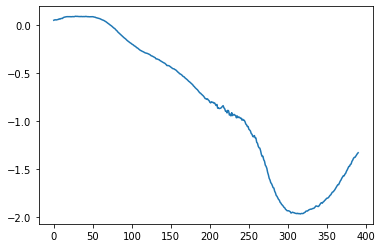

In [53]:
M.loc[:,5].plot()

<AxesSubplot:>

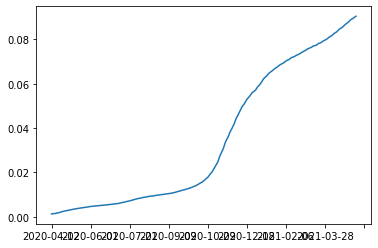

In [54]:
D.iloc[:,5].plot()

In [55]:
M

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,-0.007738,0.000372,-0.015971,-0.052660,0.000198,0.053755,-0.054645,-0.049424,0.036008,0.000246,...,0.026015,0.010516,-0.039975,-0.001419,-0.104847,-0.022606,0.017763,-0.030869,-0.025109,-0.015250
1,-0.008067,0.000379,-0.016555,-0.052420,0.000242,0.057384,-0.048413,-0.050501,0.036658,0.000118,...,0.034568,0.008197,-0.040867,-0.001942,-0.109455,-0.022210,0.017594,-0.033585,-0.027205,-0.017427
2,-0.008915,0.000390,-0.017680,-0.053481,0.000670,0.058854,-0.054278,-0.051730,0.038327,-0.000825,...,0.041384,0.007258,-0.041851,-0.002704,-0.114876,-0.022210,0.017717,-0.035405,-0.029374,-0.019353
3,-0.008404,0.000401,-0.018253,-0.054523,0.001149,0.057121,-0.056040,-0.053344,0.041164,-0.000889,...,0.052820,0.004127,-0.042528,-0.001484,-0.124315,-0.023759,0.017990,-0.036744,-0.030832,-0.021397
4,-0.009720,0.000410,-0.017589,-0.057545,0.001351,0.059356,-0.056879,-0.058807,0.044017,-0.001040,...,0.061328,0.006063,-0.042854,-0.000667,-0.131601,-0.026044,0.017496,-0.039913,-0.031862,-0.024064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0.042988,0.093536,1.000720,0.410836,0.282446,-1.377902,-0.503498,0.568379,-0.093632,0.077968,...,1.694923,2.124429,-0.079694,1.463666,-1.613038,-0.722077,-0.372283,0.045798,0.468054,-0.591152
387,0.038671,0.093662,0.999100,0.411038,0.279959,-1.364999,-0.504701,0.568719,-0.092894,0.080459,...,1.701058,2.123607,-0.080847,1.459975,-1.615303,-0.723948,-0.371285,0.048966,0.466034,-0.593650
388,0.039525,0.093864,0.997547,0.412560,0.276653,-1.352789,-0.504649,0.569170,-0.093367,0.082446,...,1.698303,2.125764,-0.080381,1.460746,-1.616462,-0.726406,-0.370669,0.053705,0.462939,-0.595257
389,0.038552,0.093996,0.994590,0.411041,0.274766,-1.339527,-0.503275,0.569510,-0.094166,0.084555,...,1.694253,2.130976,-0.079344,1.459674,-1.618932,-0.728859,-0.370215,0.057497,0.458845,-0.594046
